In [1]:
# pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import plotly.express as px
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV

In [3]:
# trained the model on these below features to predict GHI using Gradient Boosting Machines (GBM), particularly XGBoost method.
import pandas as pd
import numpy as np

# Load the dataset
df = pd.read_csv("merged_df.csv")

# Convert the 'Year', 'Month', 'Day', 'Hour', 'Minute' columns to a datetime column
df['Datetime'] = pd.to_datetime(df[['Year', 'Month', 'Day', 'Hour', 'Minute']])

# Extract temporal features
df['Year'] = df['Datetime'].dt.year
df['Month_sin'] = np.sin(2 * np.pi * df['Datetime'].dt.month / 12)
df['Month_cos'] = np.cos(2 * np.pi * df['Datetime'].dt.month / 12)
df['Day_sin'] = np.sin(2 * np.pi * df['Datetime'].dt.day / df['Datetime'].dt.days_in_month)
df['Day_cos'] = np.cos(2 * np.pi * df['Datetime'].dt.day / df['Datetime'].dt.days_in_month)
df['Hour_sin'] = np.sin(2 * np.pi * df['Datetime'].dt.hour / 24)
df['Hour_cos'] = np.cos(2 * np.pi * df['Datetime'].dt.hour / 24)

# Spatial features
# Assuming the 'Latitude' and 'Longitude' features represent the location
# which could be useful if the dataset spans multiple geographic locations
df['Latitude'] = df['Latitude'].astype(float)
df['Longitude'] = df['Longitude'].astype(float)

# Weather-related features
# 'Clearsky DHI' and 'Clearsky DNI' as features could provide a baseline for GHI
df['Clearsky DHI'] = df['Clearsky DHI'].astype(float)
df['Clearsky DNI'] = df['Clearsky DNI'].astype(float)

# Features and target variable for the model
features = [
    'Cloud Type', 'Dew Point', 'Ozone', 'Relative Humidity',
    'Solar Zenith Angle', 'Surface Albedo', 'Pressure',
    'Precipitable Water', 'Wind Direction', 'Wind Speed',
    'Year', 'Month_sin', 'Month_cos', 'Day_sin', 'Day_cos',
    'Hour_sin', 'Hour_cos', 'Latitude', 'Longitude',
    'Clearsky DHI', 'Clearsky DNI'
]

# Update the features list if you create new interaction terms or other engineered features

# Define the target variable
target = 'GHI'

# Prepare the feature matrix (X) and the target array (y)
X = df[features]
X_with_datetime = df[features + ['Datetime']]  # Temporarily include 'Datetime' for later use
y = df[target]

In [4]:
# Split the dataset into training and testing sets
X_with_datetime_train, X_with_datetime_test, y_train, y_test = train_test_split(
    X_with_datetime, y, test_size=0.2, random_state=42
)

# Extract 'Datetime' for later use before dropping it from features
Datetime_train = X_with_datetime_train['Datetime']
Datetime_test = X_with_datetime_test['Datetime']

# Drop the 'Datetime' column from the training and testing feature sets
X_train = X_with_datetime_train.drop(columns=['Datetime'])
X_test = X_with_datetime_test.drop(columns=['Datetime'])

# Now, X_train, X_test, y_train, and y_test are ready to be used for training and testing the model.


In [5]:
param_grid = {
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 3, 5],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200, 300],
    'colsample_bytree': [0.3, 0.7]
}


In [6]:
# Split the data into training and testing sets
X_with_datetime_train, X_with_datetime_test, y_train, y_test = train_test_split(X_with_datetime, y, test_size=0.2, random_state=42)


In [7]:
# # Initialize the XGBRegressor
# xgb_reg = xgb.XGBRegressor(objective='reg:squarederror')

# # Initialize the GridSearchCV object
# grid_search = GridSearchCV(estimator=xgb_reg, param_grid=param_grid,
#                            scoring='neg_mean_squared_error', cv=3, verbose=1)

# # Fit GridSearchCV to the data
# grid_search.fit(X_train, y_train)

# # Output the best parameters and score
# print(f"Best parameters: {grid_search.best_params_}")
# print(f"Best score: {-grid_search.best_score_}")


In [8]:
# print(grid_search.best_params_)


In [39]:
# Retrieve the best parameters from the grid search
# best_params = grid_search.best_params_

# # Initialize the XGBRegressor with the best parameters
# xgb_model = xgb.XGBRegressor(
#     objective ='reg:squarederror',
#     colsample_bytree = best_params['colsample_bytree'],
#     learning_rate = best_params['learning_rate'],
#     max_depth = best_params['max_depth'],
#     alpha=10,
#     n_estimators = best_params['n_estimators']
# )

xgb_model = xgb.XGBRegressor(
    objective ='reg:squarederror',
    colsample_bytree = 0.7,
    learning_rate = 0.1,
    max_depth = 7,
    alpha=10,
    n_estimators = 300
)

# Fit the model with the best parameters
xgb_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = xgb_model.predict(X_test)

predictions_with_datetime = pd.DataFrame({
    'Predicted GHI': y_pred,
    'Actual GHI': y_test
}, index=X_test.index)

# Join 'Datetime' from the original df based on the index
predictions_with_datetime = predictions_with_datetime.join(df[['Datetime']])

In [40]:
predictions_with_datetime.columns

Index(['Predicted GHI', 'Actual GHI', 'Datetime'], dtype='object')

In [42]:
# First, ensure that 'Datetime' is in the correct datetime format and set it as the index
predictions_with_datetime['Datetime'] = pd.to_datetime(predictions_with_datetime['Datetime'])
predictions_with_datetime.set_index('Datetime', inplace=True)

# Now, resample to calculate the daily average of 'Predicted GHI'
daily_avg_ghi = predictions_with_datetime.resample('D').mean()['Predicted GHI']


In [11]:
# Calculate the model performance metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Model Mean Squared Error: {mse}')
print(f'Model R^2 Score: {r2}')


Model Mean Squared Error: 2154.7950098035167
Model R^2 Score: 0.9751311874952246


In [31]:
# Display actual vs. predicted values
predictions_df = pd.DataFrame({'Actual GHI': y_test, 'Predicted GHI': y_pred})
print(predictions_df.head())

        Actual GHI  Predicted GHI
587246         234     244.991058
329396           0      -0.821701
519018          54      54.900558
526736          95     100.143005
612849         353     348.254944


In [32]:
# Assuming 'predictions_df' is your DataFrame containing both actual and predicted GHI values
predictions_df['Residuals'] = predictions_df['Actual GHI'] - predictions_df['Predicted GHI']

The residuals are centered around the zero line, which is good—it means that the model doesn't have a systematic bias to overpredict or underpredict across all ranges of predictions.

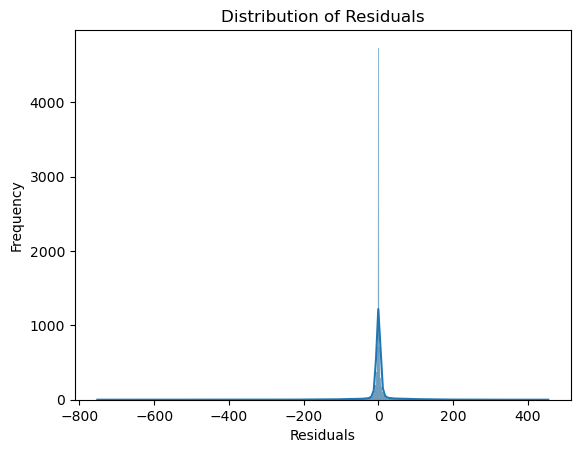

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot the distribution of residuals
sns.histplot(predictions_df['Residuals'], kde=True)
plt.title('Distribution of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()


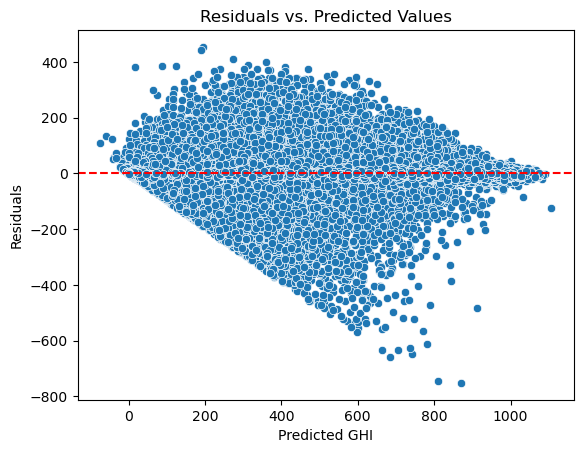

In [15]:
sns.scatterplot(x=predictions_df['Predicted GHI'], y=predictions_df['Residuals'])
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residuals vs. Predicted Values')
plt.xlabel('Predicted GHI')
plt.ylabel('Residuals')
plt.show()


In [16]:
# Summary statistics for residuals
residual_stats = predictions_df['Residuals'].describe()
print(residual_stats)


count    140160.000000
mean         -0.000417
std          46.419935
min        -751.932190
25%          -1.832645
50%           0.075881
75%           1.927134
max         453.964310
Name: Residuals, dtype: float64


In [17]:
def optimize_solar_operations(predicted_ghi, threshold=200):
    """
    Function to determine operational adjustments based on predicted GHI.

    Parameters:
    - predicted_ghi: DataFrame with datetime index and predicted GHI values.
    - threshold: GHI threshold to decide on operational adjustments.

    Returns:
    - Adjustments recommendations as a DataFrame.
    """
    # Determine when to scale up or scale down operations
    predicted_ghi['Operation'] = np.where(predicted_ghi['Predicted GHI'] > threshold, 'Scale Up', 'Scale Down')

    return predicted_ghi[['Predicted GHI', 'Operation']]

def inform_energy_trading(predicted_ghi, selling_price, buying_price, threshold=150):
    """
    Function to make energy trading decisions based on predicted GHI.

    Parameters:
    - predicted_ghi: DataFrame with datetime index and predicted GHI values.
    - selling_price: Price at which you're willing to sell excess energy.
    - buying_price: Price at which you're willing to buy additional energy.
    - threshold: GHI threshold to decide on buying or selling energy.

    Returns:
    - Trading recommendations as a DataFrame.
    """
    predicted_ghi['Trade Decision'] = np.where(predicted_ghi['Predicted GHI'] > threshold,
                                               f"Sell at ${selling_price}/kWh",
                                               f"Buy at ${buying_price}/kWh")

    return predicted_ghi[['Predicted GHI', 'Trade Decision']]


In [23]:
operations_df = optimize_solar_operations(predictions_df)
trading_df = inform_energy_trading(predictions_df, selling_price=0.10, buying_price=0.08)

# After getting 'operations_df' and 'trading_df', reset their index to make 'Datetime' a column
operations_df.reset_index(inplace=True)
trading_df.reset_index(inplace=True)

print(operations_df.head())
print(trading_df.head())

   index  Predicted GHI   Operation
0      0     244.991058    Scale Up
1      1      -0.821701  Scale Down
2      2      54.900558  Scale Down
3      3     100.143005  Scale Down
4      4     348.254944    Scale Up
   index  Predicted GHI    Trade Decision
0      0     244.991058  Sell at $0.1/kWh
1      1      -0.821701  Buy at $0.08/kWh
2      2      54.900558  Buy at $0.08/kWh
3      3     100.143005  Buy at $0.08/kWh
4      4     348.254944  Sell at $0.1/kWh


Scatter Plot (Operations): Highlights specific days with decisions to scale up or scale down operations based on predicted GHI, aiding in operational planning for energy production.

Scatter Plot (Trading): Marks days where energy trading decisions (buy or sell) are suggested, assisting in strategic energy trading and grid management.

This visualization offers a comprehensive view of how the model's predictions can inform various decision-making processes in the context of solar energy management. It visually integrates predictive insights with actionable decisions, supporting stakeholders in making informed strategies related to energy production, grid management, and solar infrastructure investment.

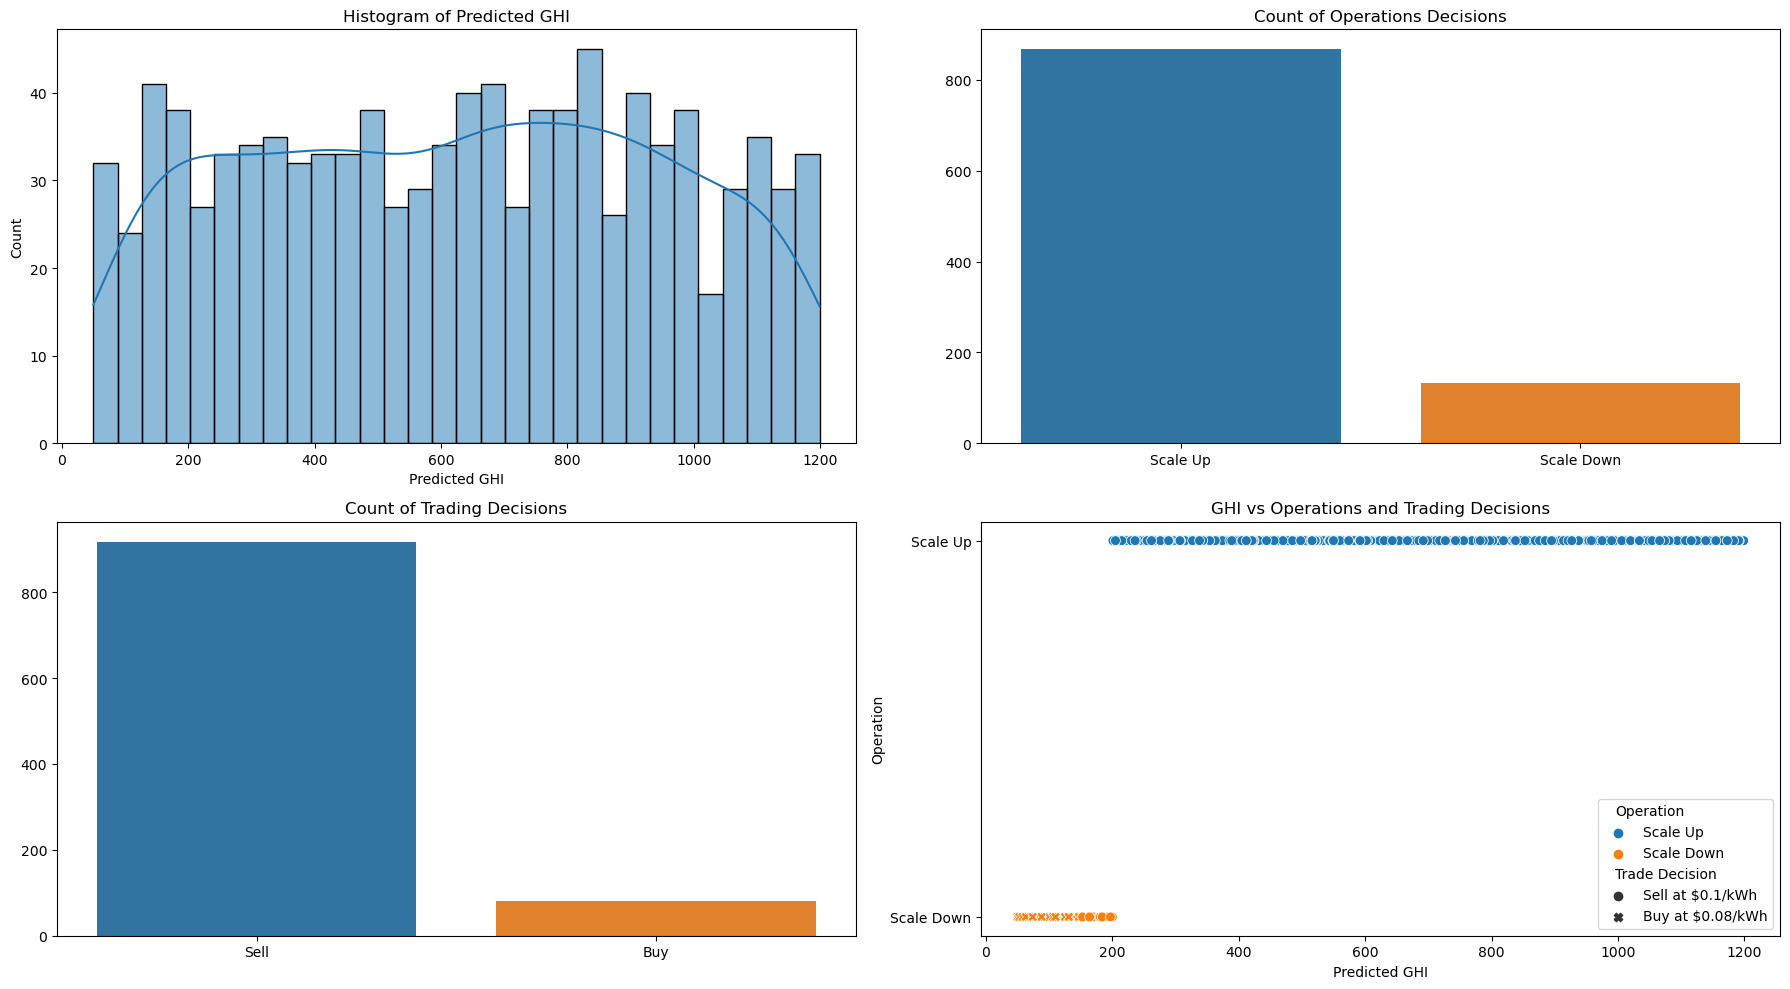

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Generate sample data for demonstration purposes
np.random.seed(0)
sample_data = {
    'Predicted GHI': np.random.randint(50, 1200, 1000),  # Random GHI values
}
predicted_ghi = pd.DataFrame(sample_data)

# Apply the functions to make decisions
operations_df = optimize_solar_operations(predicted_ghi, threshold=200)
trading_df = inform_energy_trading(predicted_ghi, selling_price=0.10, buying_price=0.08, threshold=150)

# Merge the operations and trading decisions for visualization
combined_df = operations_df.join(trading_df['Trade Decision'])

# Now, let's create visualizations
plt.figure(figsize=(18, 10))

# Histogram of Predicted GHI
plt.subplot(2, 2, 1)
sns.histplot(data=combined_df, x='Predicted GHI', bins=30, kde=True)
plt.title('Histogram of Predicted GHI')

# Bar chart for operations decisions
plt.subplot(2, 2, 2)
operations_count = combined_df['Operation'].value_counts()
sns.barplot(x=operations_count.index, y=operations_count.values)
plt.title('Count of Operations Decisions')

# Bar chart for trading decisions
plt.subplot(2, 2, 3)
trading_df['Trade Type'] = trading_df['Trade Decision'].apply(lambda x: 'Sell' if 'Sell' in x else 'Buy')
trading_count = trading_df['Trade Type'].value_counts()
sns.barplot(x=trading_count.index, y=trading_count.values)
plt.title('Count of Trading Decisions')

# Scatter plot for GHI vs Operations
plt.subplot(2, 2, 4)
sns.scatterplot(data=combined_df, x='Predicted GHI', y='Operation', hue='Operation', style='Trade Decision', s=50)
plt.title('GHI vs Operations and Trading Decisions')

plt.tight_layout()
plt.show()


Energy Production: Periods with higher average predicted GHI suggest potential for increased solar energy production. This could inform operational planning, such as scheduling maintenance during lower production periods.

Grid Management: Understanding fluctuations in solar energy production can help grid operators anticipate changes in supply. Days with low predicted GHI might require support from other energy sources to meet demand.

Investment in Solar Infrastructure: Long-term trends in predicted GHI could inform decisions about where and when to invest in additional solar infrastructure. Consistently high GHI areas might be prime candidates for new solar projects.

This visualization provides a high-level overview of expected solar energy production capabilities, which can be a valuable tool in strategic planning and operational adjustments for energy companies and grid operators. It simplifies complex predictions into actionable insights, facilitating informed decision-making related to energy production, grid management, and infrastructure investments.

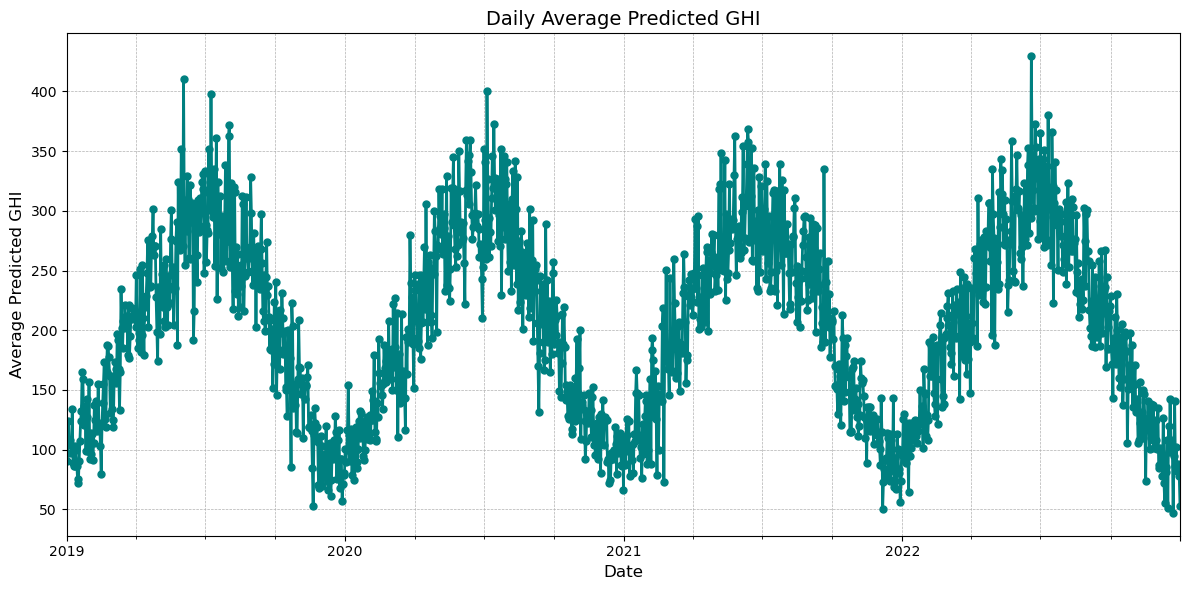

In [43]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
daily_avg_ghi.plot(kind='line', color='teal', marker='o', linestyle='-', linewidth=2, markersize=5)
plt.title('Daily Average Predicted GHI', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Average Predicted GHI', fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()
